# Разработка агрессивного поведения человека

Необходимо по видео определить когда на экране начинается агрессивное поведение. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torchvision
from datetime import timedelta
import cv2
import numpy as np
import os
from torch import nn
from torch.optim import lr_scheduler
import time
from tqdm import tqdm
from skimage.transform import resize

Нам дан один большой [видео](https://drive.google.com/file/d/1xdQYroHTppnqpVYLL8m1xfzLlW0wSCgg/view?usp=sharing) файл продолжительностью около 1,5 часов. Кроме того имеется [csv_file](https://drive.google.com/file/d/1TYGF9_5p-yc5jILu50DxHXkGoVT6GyNO/view?usp=sharing), в котором указанный видеофайл поделен на временные промежутки (в сек) и указаны целевые метки класса. 

In [5]:
fight_data = pd.read_csv('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.txt', header = None, sep =' ')
fight_data

,0,1,2
0,0,19,1
1,19,39,0
2,39,58,0
3,58,77,1
4,77,96,0
...,...,...,...
234,4547,4566,0
235,4566,4585,0
236,4585,4605,1
237,4605,4625,1


Выведем основные параметры нашего видеофайла. 

In [6]:
cap = cv2.VideoCapture('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
time = (count / fps) / 60
fps, count, time

(240.0, 1114861.0, 77.42090277777778)

Продолжительность 77 минут, качество 240 frame/sec, что слишком много для наших вычислительных мощностей. Напишем функцию для предобработки нашего видеофайла для обучения. Мы будем уменьшать исходную размерность картинки и захватывать только определенное кол-во фреймов для каждого отрезка видео.

In [7]:
from skimage.transform import resize
from torch.utils.data import Dataset 

def capture(video_path, start, end,label, timesep,rgb,h,w):
    tmp = []
    frames = np.zeros((timesep,rgb,h,w), dtype=np.float)
    i=0
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Get the total number of frames in the video.
    video_frames_count = int((end - start)*fps)

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/timesep), 1)

    for frame_counter in range(timesep):
      
        # Set the current frame position of the video.
        cap.set(cv2.CAP_PROP_POS_FRAMES, start*fps + frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = cap.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.

        frm = resize(frame,(h, w,rgb))  # resize is   =>    
        frm = np.expand_dims(frm,axis=0)
        frm = np.moveaxis(frm, -1, 1)
        if(np.max(frm)>1):
            frm = frm/255.0
        frames[frame_counter][:] = frm
    
    return {'video' : frames, 'label' : label}

Чтобы как-то ускорить процесс обработки видео используем все два процессора которые нам предоставляет google colab.

In [8]:
import pickle
from multiprocessing import Pool
def create_frame(video_path, annotation_path, timesep=30,rgb=3,h=120,w=120, num_workers = 2):
    flag = False
    torch.cuda.empty_cache()
    annotation = pd.read_csv(annotation_path, header = None, sep = ' ')
    labels = np.zeros(annotation.shape[0])
    pool = Pool(num_workers)
    dset_list = []
    i = 0
    while i < annotation.shape[0]-1:
        params = [(video_path,annotation.loc[i+j,0],annotation.loc[i+j,1], annotation.loc[i+j, 2],timesep,rgb,h,w) for j in range(num_workers)]
        print(len(params), i)
        print(params)
        dset_list.extend(pool.starmap(capture, params))
        i += len(params)
        torch.cuda.empty_cache()
    else:
        label = annotation.loc[i, 2]
        start1, end1 = annotation.loc[i,0],annotation.loc[i,1]
        print('{}:start({})-end({})'.format(i, start1, end1, ))
        dset_list.append(capture(video_path,start1,end1,label, timesep,rgb,h,w))
               #frames_array[i][:] = capture(video_path,start,end, timesep,rgb,h,w)
        torch.cuda.empty_cache()
    import pickle

    with open('/content/test3.pickle', 'wb') as handle:
        pickle.dump(dset_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return dset_list



Обработка видео занимает продолжительное время, поэтому сохраним наши данные, и уже их будем использовать для обучения модели и подбора параметров.

In [9]:
%%time
create_frame('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4','/content/gdrive/MyDrive/ISS_Hakaton/fight_train.txt',  timesep = 40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


2 0
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 0, 19, 1, 40, 3, 120, 120), ('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 19, 39, 0, 40, 3, 120, 120)]
2 2
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 39, 58, 0, 40, 3, 120, 120), ('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 58, 77, 1, 40, 3, 120, 120)]
2 4
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 77, 96, 0, 40, 3, 120, 120), ('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 96, 116, 0, 40, 3, 120, 120)]
2 6
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 116, 135, 0, 40, 3, 120, 120), ('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 135, 155, 0, 40, 3, 120, 120)]
2 8
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 155, 174, 0, 40, 3, 120, 120), ('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 174, 193, 0, 40, 3, 120, 120)]
2 10
[('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', 193, 213, 1, 40, 3, 120, 120), ('/content/gdrive/MyDriv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


CPU times: user 1min 19s, sys: 19.4 s, total: 1min 38s
Wall time: 1h 15min 18s


[{'label': 1,
  'video': array([[[[0.36470588, 0.37647059, 0.38431373, ..., 0.49019608,
            0.47843137, 0.49019608],
           [0.37647059, 0.37647059, 0.36862745, ..., 0.48823529,
            0.47647059, 0.48627451],
           [0.34117647, 0.35294118, 0.36078431, ..., 0.49607843,
            0.48627451, 0.49019608],
           ...,
           [0.21960784, 0.22352941, 0.22745098, ..., 0.55294118,
            0.54509804, 0.54117647],
           [0.21960784, 0.22352941, 0.22745098, ..., 0.55294118,
            0.54509804, 0.54117647],
           [0.22352941, 0.22745098, 0.22745098, ..., 0.54901961,
            0.54705882, 0.54117647]],
  
          [[0.36078431, 0.37843137, 0.38823529, ..., 0.43921569,
            0.42745098, 0.43921569],
           [0.3745098 , 0.38039216, 0.37254902, ..., 0.44117647,
            0.42745098, 0.43921569],
           [0.34117647, 0.35686275, 0.36470588, ..., 0.44705882,
            0.43529412, 0.43921569],
           ...,
           [0.41176471,

## Загрузка обработанных данных

In [10]:
import pickle
with open('/content/test3.pickle', 'rb') as handle:
    dset = pickle.load(handle)
dset[0]['video'].shape

(40, 3, 120, 120)

 Разделим наши данные на тренировочную и тестовую выборку, предварительно стратифицировав данные по целевому признаку. Передадим в Dataloader для дальнейшего обучения.

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import torch
#dset = VideoDataset('/content/gdrive/MyDrive/ISS_Hakaton/fight_train.mp4', '/content/gdrive/MyDrive/ISS_Hakaton/fight_train.txt', timesep = 40)
labels = [x['label'] for x in dset]
indices = list(range(len(labels)))
ind_train, ind_test, _, _ = train_test_split(indices, labels, test_size=0.2, random_state=139, stratify=labels)
num_workers = 2
trainset = torch.utils.data.Subset(dset, ind_train)                           
valset = torch.utils.data.Subset(dset, ind_test)
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, num_workers=num_workers, batch_size = batch_size)

testloader = torch.utils.data.DataLoader(valset, num_workers=num_workers, batch_size = batch_size)

loaders = {'train': trainloader, 'val': testloader}

## Обучение модели

Для обучения мы будем использовать комбинацию сверточной нейронной сети и LSTM. В качестве сверточной модели мы выбрали достаточно легкую, но обладающую высоким качеством mobilenet_v3_large. 

Заранее предусмотрим возможность заморозки слоев нашей сверточной модели.

In [25]:
def init_model(device, freeze_lay = None):
    initial_model = torchvision.models.mobilenet_v3_large(pretrained=True).features
    set_requires_grad(initial_model,freeze_lay, True)
    initial_model.to(device)
    return initial_model
  
def set_requires_grad(model, freeze_lay = None, value=False):
  if not freeze_lay:
    for param in model.parameters():
        param.requires_grad = value
  else:
    for param in model[:-freeze_lay].parameters():
        param.requires_grad = False

Размер фрейма после свертки 3-х мерный (C*W*H), а видео-файл должен представлять собой 4-х мерный тензор (Timesep*C*W*H). На следующем этапе преобразуем наши результаты свертки в хронологическом порядке,чтобы у нас получилась пространственно-временная модель, так как последовательнасть крайне важна при обработке видео.

In [26]:
class TimeWarp(nn.Module):
    def __init__(self, baseModel, method='sqeeze'):
        super(TimeWarp, self).__init__()
        self.baseModel = baseModel
        self.method = method
 
    def forward(self, x):
        #print(x.shape, 'x.shape')
        batch_size, time_steps, C, H, W = x.size()
        if self.method == 'loop':
            output = []
            for i in range(time_steps):
                #input one frame at a time into the basemodel
                x_t = self.baseModel(x[:, i, :, :, :].to(device))
                # Flatten the output
                x_t = x_t.reshape(x_t.size(0), -1)
                output.append(x_t)
            #end loop
            #make output as  ( samples, timesteps, output_size)
            x = torch.stack(output, dim=0).transpose_(0, 1)
            output = None # clear var to reduce data  in memory
            x_t = None  # clear var to reduce data  in memory
        else:
            # reshape input  to be (batch_size * timesteps, input_size)
            x = x.contiguous().view(batch_size * time_steps, C, H, W)
            x = self.baseModel(x)
            x = x.view(x.size(0), -1)
            #make output as  ( samples, timesteps, output_size)
            x = x.contiguous().view(batch_size , time_steps , x.size(-1))
        return x

class extractlastcell(nn.Module):
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]


Соберем нашу готовую модель передав 4-х мерный тензор в LSTM, который хорошо работает с последовательностями, а на выходе получаем целевой признак.

In [27]:
def videoFightModel(device, layers_to_unfreeze=None):
    # Create model
    num_classes = 2
    dr_rate= 0.2
    pretrained = True
    rnn_hidden_size = 80
    rnn_num_layers = 1
    baseModel =  init_model(device, freeze_lay = layers_to_unfreeze)
    num_features = 15360
    # Example of using Sequential
    model = nn.Sequential(TimeWarp(baseModel,method='not_loop'),
                        nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers , batch_first=True , bidirectional=True ),
                        extractlastcell(),
                            nn.Linear(160, 256),
                        nn.ReLU(),
                        nn.Dropout(dr_rate),
    nn.Linear(256, num_classes)            )
    return model

Приступаем к обучению модели, в процессе обучения мы будем сохранять модель с наилучшей точностью по валидационной выборке.

In [81]:
import time
def train_model(model, dataloaders, criterion, optimizer, scheduler,
                phases, num_epochs=3, show_image = True):
    start_time = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = np.inf
    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}
    MODEL_WEIGHTS = '/content/gdrive/MyDrive/ISS_Hakaton/weight.pt'
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        j = 0
        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for batch in tqdm(dataloaders[phase], total=n_batches):
                inputs = batch['video'].to(device).float()
                labels = batch['label'].to(device)
                #print('labels',labels, 'shape', labels.shape, 'inputs shape', inputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    #print('outputs', outputs, 'shape', outputs.shape)

                    _, preds = torch.max(outputs, 1)
                    #print('preds', preds, 'shape', preds.shape)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':
                      scheduler.step(loss)

                # statistics
                running_loss += loss.cpu().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            elif phase == 'val' and epoch_acc == best_acc and loss < best_loss:
                best_loss = loss 
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    torch.save(best_model_wts, MODEL_WEIGHTS)
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = videoFightModel(device)
model.to(device)

train_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(train_optimizer, mode='min')
#lr_scheduler.StepLR(train_optimizer, step_size=10, gamma=0.3)

criterion = nn.CrossEntropyLoss()

# Pretrain
train_results = train_model(model, loaders, criterion, train_optimizer,exp_lr_scheduler,phases=['train', 'val'], num_epochs=30)

Epoch 0/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.50it/s]


train Loss: 0.5836 Acc: 0.7330


100%|██████████| 12/12 [00:00<00:00, 12.68it/s]


val Loss: 0.5721 Acc: 0.7917

Epoch 1/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.56it/s]


train Loss: 0.4404 Acc: 0.8901


100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


val Loss: 0.5868 Acc: 0.6042

Epoch 2/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.59it/s]


train Loss: 0.4087 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.63it/s]


val Loss: 0.5778 Acc: 0.6667

Epoch 3/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.57it/s]


train Loss: 0.4060 Acc: 0.9319


100%|██████████| 12/12 [00:00<00:00, 12.68it/s]


val Loss: 0.5618 Acc: 0.7708

Epoch 4/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4042 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.58it/s]


val Loss: 0.5623 Acc: 0.7917

Epoch 5/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.58it/s]


train Loss: 0.4061 Acc: 0.9215


100%|██████████| 12/12 [00:00<00:00, 12.72it/s]


val Loss: 0.5571 Acc: 0.7500

Epoch 6/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.55it/s]


train Loss: 0.4064 Acc: 0.9319


100%|██████████| 12/12 [00:00<00:00, 12.76it/s]


val Loss: 0.5524 Acc: 0.7917

Epoch 7/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.55it/s]


train Loss: 0.4059 Acc: 0.9215


100%|██████████| 12/12 [00:00<00:00, 12.66it/s]


val Loss: 0.5264 Acc: 0.7917

Epoch 8/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.56it/s]


train Loss: 0.4027 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


val Loss: 0.4963 Acc: 0.7708

Epoch 9/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.42it/s]


train Loss: 0.4037 Acc: 0.9476


100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


val Loss: 0.4786 Acc: 0.8125

Epoch 10/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.49it/s]


train Loss: 0.4052 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.47it/s]


val Loss: 0.4605 Acc: 0.8125

Epoch 11/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4065 Acc: 0.9372


100%|██████████| 12/12 [00:00<00:00, 12.54it/s]


val Loss: 0.4504 Acc: 0.8333

Epoch 12/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


train Loss: 0.4118 Acc: 0.9215


100%|██████████| 12/12 [00:00<00:00, 12.62it/s]


val Loss: 0.4424 Acc: 0.8333

Epoch 13/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.55it/s]


train Loss: 0.4024 Acc: 0.9476


100%|██████████| 12/12 [00:00<00:00, 12.59it/s]


val Loss: 0.4359 Acc: 0.8542

Epoch 14/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4050 Acc: 0.9319


100%|██████████| 12/12 [00:00<00:00, 12.43it/s]


val Loss: 0.4321 Acc: 0.8542

Epoch 15/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4002 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.12it/s]


val Loss: 0.4302 Acc: 0.8542

Epoch 16/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4039 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


val Loss: 0.4285 Acc: 0.8542

Epoch 17/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


train Loss: 0.4034 Acc: 0.9372


100%|██████████| 12/12 [00:00<00:00, 12.58it/s]


val Loss: 0.4279 Acc: 0.8750

Epoch 18/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4048 Acc: 0.9319


100%|██████████| 12/12 [00:00<00:00, 12.75it/s]


val Loss: 0.4274 Acc: 0.8750

Epoch 19/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4055 Acc: 0.9267


100%|██████████| 12/12 [00:00<00:00, 12.44it/s]


val Loss: 0.4272 Acc: 0.8750

Epoch 20/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


train Loss: 0.4065 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.54it/s]


val Loss: 0.4270 Acc: 0.8750

Epoch 21/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4078 Acc: 0.9215


100%|██████████| 12/12 [00:00<00:00, 12.30it/s]


val Loss: 0.4269 Acc: 0.8750

Epoch 22/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4038 Acc: 0.9634


100%|██████████| 12/12 [00:00<00:00, 12.67it/s]


val Loss: 0.4269 Acc: 0.8750

Epoch 23/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4040 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.72it/s]


val Loss: 0.4268 Acc: 0.8750

Epoch 24/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


train Loss: 0.4047 Acc: 0.9372


100%|██████████| 12/12 [00:00<00:00, 12.38it/s]


val Loss: 0.4268 Acc: 0.8750

Epoch 25/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4092 Acc: 0.9424


100%|██████████| 12/12 [00:00<00:00, 12.44it/s]


val Loss: 0.4268 Acc: 0.8750

Epoch 26/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


train Loss: 0.4080 Acc: 0.9267


100%|██████████| 12/12 [00:00<00:00, 12.48it/s]


val Loss: 0.4267 Acc: 0.8750

Epoch 27/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.53it/s]


train Loss: 0.4058 Acc: 0.9476


100%|██████████| 12/12 [00:00<00:00, 12.60it/s]


val Loss: 0.4267 Acc: 0.8750

Epoch 28/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.56it/s]


train Loss: 0.3997 Acc: 0.9319


100%|██████████| 12/12 [00:00<00:00, 12.71it/s]


val Loss: 0.4267 Acc: 0.8750

Epoch 29/29
----------


100%|██████████| 48/48 [00:07<00:00,  6.54it/s]


train Loss: 0.4021 Acc: 0.9529


100%|██████████| 12/12 [00:00<00:00, 12.28it/s]


val Loss: 0.4267 Acc: 0.8750

Training complete in 4m 10s


Мы видим неплохой результат на валидационной и тренировочной выборке, модель не сильно переобучается, но дает неплохую точность.
Попробуем оценить нашу модель по всему видеофайлу, потому что у нас не так много данных.

In [83]:
train_results[1]['train'] = [x.cpu() for x in train_results[1]['train']]
train_results[1]['val'] = [x.cpu() for x in train_results[1]['val']]

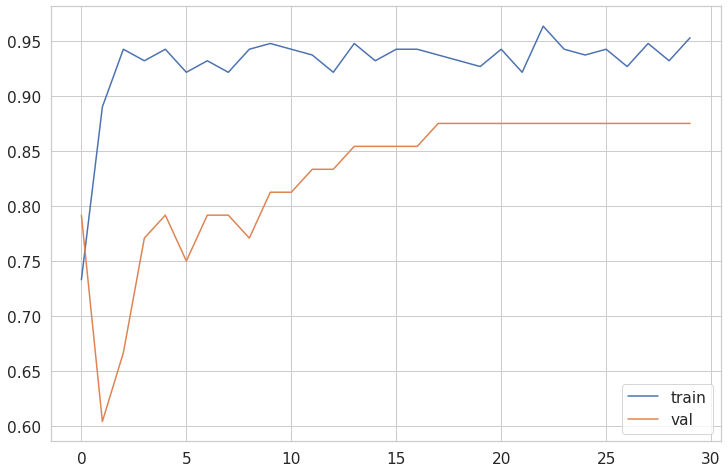

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
losses = train_results[1]
sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [85]:
testloader = torch.utils.data.DataLoader(dset, num_workers=num_workers, batch_size = batch_size)
testloader

In [86]:
def evaluate(model, dataloaders):
    model.eval()
    data_size = 0
    runninig_correct = 0
    for data in dataloaders:
        # получаем картинки и метки
        inputs, labels = data['video'], data['label']
        data_size += len(labels)
        # переносим на gpu, если возможно
        if True:
            inputs = inputs.cuda().float()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / data_size

testloader = torch.utils.data.DataLoader(dset, num_workers=num_workers, batch_size = batch_size)
best_model = train_results[0]
score = evaluate(best_model, testloader)
score

0.891213389121339